In [589]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn import cross_validation, metrics
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, accuracy_score,log_loss, f1_score
from sklearn.grid_search import GridSearchCV 
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


In [590]:
def animalDF(file):
    df = pd.read_csv(file)
    print(df.info())
    return df

# Data Exploration

Importing in the training data. Here we can see that some of the features have null values in them. Lets see how exactly how much from each column.

In [591]:
animals = animalDF('files/train.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26729 entries, 0 to 26728
Data columns (total 10 columns):
AnimalID          26729 non-null object
Name              19038 non-null object
DateTime          26729 non-null object
OutcomeType       26729 non-null object
OutcomeSubtype    13117 non-null object
AnimalType        26729 non-null object
SexuponOutcome    26728 non-null object
AgeuponOutcome    26711 non-null object
Breed             26729 non-null object
Color             26729 non-null object
dtypes: object(10)
memory usage: 2.0+ MB
None


Here we see that we have four features that have missing values "Name", "OutcomeSubtype", "SexuponOutcome", and "AgeuponOutcome." Both "Name" and "OutcomeSubtype" are missing a significant amount of data within them while "SexuponOutcome" and "AgeuponOutcome" aren't missing that many. We'll fix these in a moment.

In [592]:
animals.isnull().sum()

AnimalID              0
Name               7691
DateTime              0
OutcomeType           0
OutcomeSubtype    13612
AnimalType            0
SexuponOutcome        1
AgeuponOutcome       18
Breed                 0
Color                 0
dtype: int64

Lets look at the first five rows of this data set.

In [593]:
animals.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


Above I can see several things that I want to change. I see values such as "Neutered Male" and "Spayed Female" in the "SexuponOutcome" feature. This can be separated into two different features itself, the sex of the animal and whether or not the animal is spayed, neutered, or intact. Also the feature "AgeuponOutcome" I would like to get into one catergory of age such as years, months, weeks, or days. "Breed" and "Color" are also two features that I may want to change.

In [594]:
# Splitting SexuponOutcome feature into sex and neutered.
def sexSplit(data):
    sex = str(data)
    if 'Male' in sex:
        return 'Male'
    else:
        return 'Female'
    
def intactSplit(data):
    intact = str(data)
    if 'Neutered' in intact or 'Spayed' in intact:
        return 'Neutered'
    elif 'Intact' in intact:
        return 'Intact'
    else:
        return "Unknown"
    
animals['Sex'] = animals.SexuponOutcome.apply(sexSplit)
animals['Neutered'] = animals.SexuponOutcome.apply(intactSplit)

In [595]:
animals = animals.drop(['SexuponOutcome', 'OutcomeSubtype'], axis=1)

In [596]:
def get_mix(data):
    mix = str(data)
    if 'Mix' in mix or '/' in mix:
        return 'Hybrid'
    else:
        return 'Purebred'
animals['Breed'] = animals.Breed.apply(get_mix)

In [597]:
animals['AgeuponOutcome'] = animals['AgeuponOutcome'].fillna('1 year')

In [598]:
def ageYears(data):
    x = str(data)
    age = int(x.split()[0])
    if 'year' in x :
        return age 
    elif 'month' in x:
        return age / 12.
    elif 'week' in x:
        return age / 52.
    elif 'day' in x:
        return age / 365.
    else:
        return 0

animals['AgeInYears'] = animals.AgeuponOutcome.apply(ageYears)
animals = animals.drop('AgeuponOutcome', axis=1)

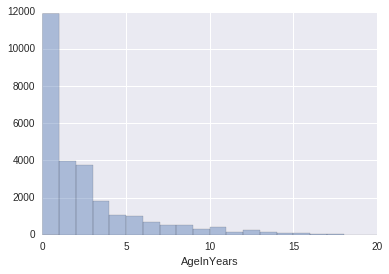

In [599]:
sns.distplot(animals.AgeInYears, bins = 20, kde=False)

In [600]:
def ageCategory(x):
    if x < 1:
        return 'Baby'
    elif x < 5:
        return 'Young adult'
    elif x < 10:
        return 'Adult'
    else:
        return 'Old'
animals['AgeCategory'] = animals.AgeInYears.apply(ageCategory)

In [601]:
import re
def color(data):
    x = str(data)
    
    split = re.split('/| ', x)
    return split[0]
    
animals['Color'] = animals.Color.apply(color)

In [602]:
animals.head()

,AnimalID,Name,DateTime,OutcomeType,AnimalType,Breed,Color,Sex,Neutered,AgeInYears,AgeCategory
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,Dog,Hybrid,Brown,Male,Neutered,1.000000,Young adult
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Cat,Hybrid,Cream,Female,Neutered,1.000000,Young adult
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Dog,Hybrid,Blue,Male,Neutered,2.000000,Young adult
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Cat,Hybrid,Blue,Male,Intact,0.057692,Baby
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Dog,Hybrid,Tan,Male,Neutered,2.000000,Young adult


# Exploratory Visualization

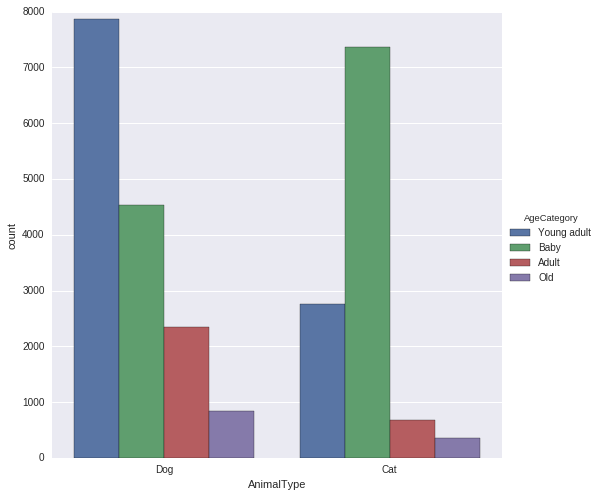

In [603]:
sns.factorplot(data=animals, x='AnimalType', kind='count', hue='AgeCategory', size=7)

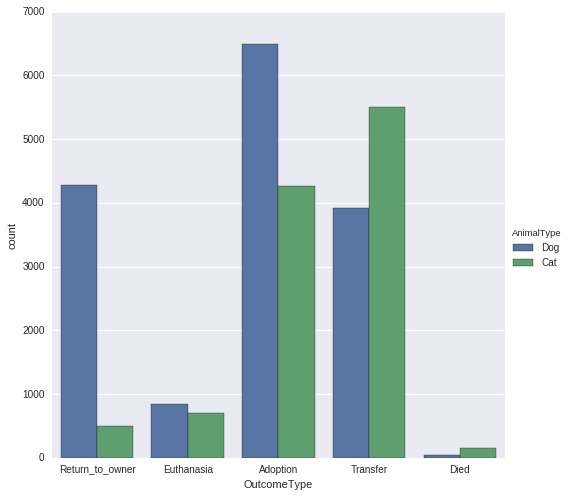

In [604]:
sns.factorplot(data=animals, x='OutcomeType', hue='AnimalType', kind='count', size=7)

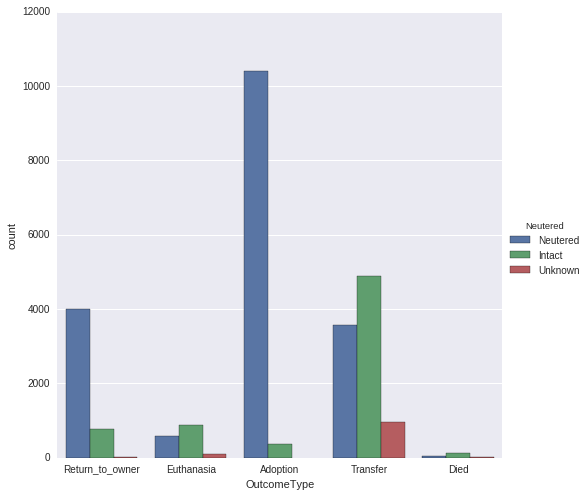

In [605]:
sns.factorplot(data=animals, x='OutcomeType', hue='Neutered', kind='count', size=7)

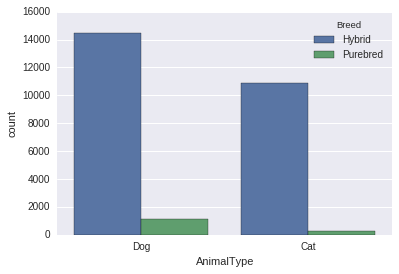

In [608]:
sns.countplot(data=animals, x='AnimalType',hue='Breed')

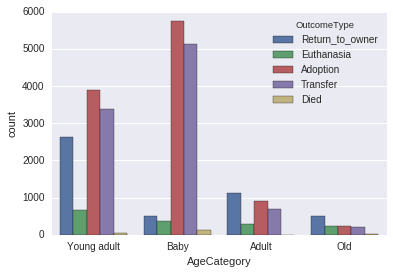

In [609]:
sns.countplot(data=animals, x='AgeCategory',hue='OutcomeType')